In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset,DataLoader
import torchvision 
from torchvision import transforms, models
from tqdm.notebook import tqdm
from PIL import Image
import seaborn as ss
from collections import OrderedDict


In [2]:
from glob import glob
import torch.nn.functional as F
from torch import nn, optim

In [3]:
data_dir = {
    "train" : "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/",
    "valid": "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/validation/",
    "test" : "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/test/"
}

In [4]:
label_csv = {"train": '/media/brats/DRIVE1/akansh/DeepXrays/Data/processed/train_labels.csv',
            "valid": "/media/brats/DRIVE1/akansh/DeepXrays/Data/processed/validation_labels.csv",
            "test": "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/submission.csv"}

In [5]:
train = pd.read_csv(label_csv['train'])
valid = pd.read_csv(label_csv['valid'])
test = pd.read_csv(label_csv['test'])

In [6]:
filenames = []
for root, dirs, files in os.walk(data_dir['train']):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png') :
            filenames.append(file)
    

In [7]:
len(filenames)

17958

In [8]:
### Dataloader
class covid_dataset(Dataset):
    def __init__(self, image_loc, label_loc, transform, data_type = 'train'):
        filenames = []
        for root, dirs, files in os.walk(image_loc):
            for file in files:
                if file.endswith('.jpg') == True or file.endswith('.png') == True :
                    filenames.append(file)
#         print(len(filenames))
        if data_type == 'train' or data_type == 'valid':
            self.full_filenames = glob(image_loc+'*/*.*')
        else:
            self.full_filenames = glob(image_loc+'*.*')
#         print(len(self.full_filenames))
            
            
        label_df = pd.read_csv(label_loc)
        label_df.set_index("case", inplace = True)
        self.labels = [label_df.loc[filename].values[0] for filename in filenames]
        
        self.transform = transform
        
    def __len__(self):
        return len(self.full_filenames)
    
    def __getitem__(self,idx):
        image = Image.open(self.full_filenames[idx])
        image = image.convert('RGB')
        image = self.transform(image)
        return image, self.labels[idx]
        

In [9]:
data_transforms = {
    
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop((224,224)),
        transforms.RandomVerticalFlip(p =.5),
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.ColorJitter((0.85,1.05)),
        transforms.RandomRotation((-30,30)),
        transforms.ToTensor(),
        transforms.Normalize([0.5027,0.5027,0.5027],[0.2466, 0.2466, 0.2466])
        
    ]),
    
    'valid' : transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5027,0.5027,0.5027],[0.2466, 0.2466, 0.2466])
    ])
    
    
}

In [10]:
valid_data = covid_dataset(image_loc = data_dir['valid'],
                          label_loc = label_csv['valid'],
                          transform = data_transforms['valid'],
                          data_type = 'valid')

train_data = covid_dataset(image_loc = data_dir['train'],
                          label_loc = label_csv['train'],
                          transform = data_transforms['train'],
                          data_type = 'train')


In [11]:
trainloader = DataLoader(train_data,batch_size = 64,shuffle = True)
validloader = DataLoader(valid_data,batch_size = 32,shuffle = False)

In [12]:
from efficientnet_pytorch import EfficientNet

In [13]:
model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=3)

Loaded pretrained weights for efficientnet-b3


In [14]:
for param in model.parameters():
    param.requires_grad = True

In [15]:
device = 'cuda'

In [16]:
model = model.cuda()

In [17]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_siz

In [18]:
def calc_confusion_matrix(model, loader, device, nb_classes):
    confusion_matrix = np.zeros((nb_classes, nb_classes))
    with torch.no_grad():
        for i, (inputs, classes) in tqdm(enumerate(loader)):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    return confusion_matrix

### Exploaring Transforms

In [19]:
image_1_cov = Image.open("/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/covid/covid-0001292.jpg")
image_2_cov = Image.open( '/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/covid/covid-0001128.jpg',)

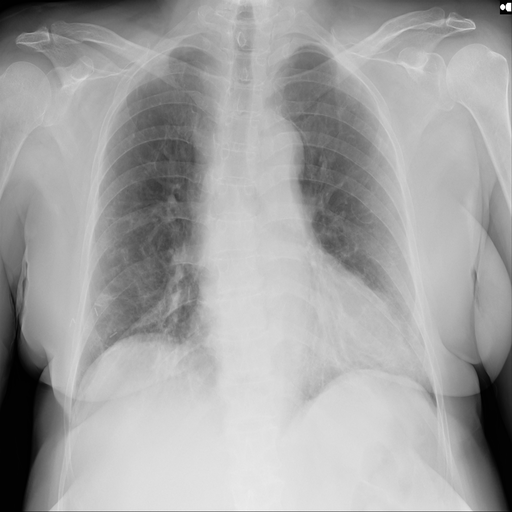

In [36]:
image_2_cov

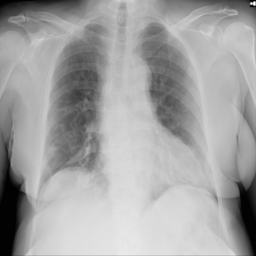

In [29]:
transforms.Resize((256,256))(image_2_cov)

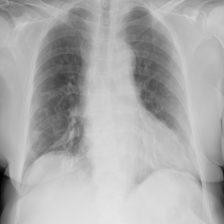

In [15]:
transforms.CenterCrop((224,224))(transforms.Resize((256,256))(image_2_cov))

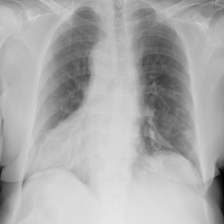

In [32]:
transforms.RandomHorizontalFlip(p = 1)(transforms.CenterCrop((224,224))(transforms.Resize((256,256))(image_2_cov)))

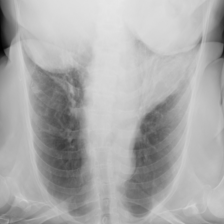

In [33]:
transforms.RandomVerticalFlip(p =.5)(transforms.CenterCrop((224,224))(transforms.Resize((256,256))(image_2_cov)))

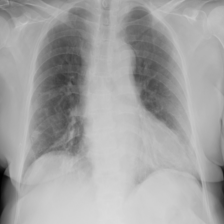

In [34]:
transforms.ColorJitter((0.85,1.05))(transforms.CenterCrop((224,224))(transforms.Resize((256,256))(image_2_cov)))

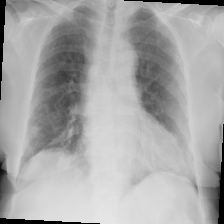

In [35]:
transforms.RandomRotation((30))(transforms.CenterCrop((224,224))(transforms.Resize((256,256))(image_2_cov)))

### Training

In [19]:
import torch.nn.functional as F

In [20]:
device = 'cuda'

In [21]:
critertion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1,patience = 5)
epochs = 25
valid_loss_min = np.Inf

In [22]:
def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred, dim =1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [24]:
train_loss_hist = []
valid_loss_hist = []
train_acc_hist = []
valid_acc_hist = []


for i in range(epochs):
    
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0 
    
    
    model.train()
    
    for images,labels in tqdm(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        
        ps = model(images)
        loss = critertion(ps,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc += accuracy(ps,labels)
        train_loss +=loss.item()
        
    avg_train_acc = train_acc / len(trainloader)
    train_acc_hist.append(avg_train_acc)
    avg_train_loss = train_loss / len(trainloader)
    train_loss_hist.append(avg_train_loss)
    
    model.eval()
    with torch.no_grad():
        for images,labels in tqdm(validloader):
            images = images.to(device)
            labels = labels.to(device)
            
            ps = model(images)
            loss = critertion(ps,labels)
            
            valid_acc += accuracy(ps,labels)
            valid_loss += loss.item()
            
        avg_valid_acc = valid_acc / len(validloader)
        valid_acc_hist.append(avg_valid_acc)
        avg_valid_loss = valid_loss / len(validloader)
        valid_loss_hist.append(avg_valid_loss)
        
        schedular.step(avg_valid_loss)
        
        if avg_valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).Saving model ...'.format(valid_loss_min,avg_valid_loss))
            torch.save({
                'epoch' : i,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                'valid_loss_min' : avg_valid_loss
            },'efficientNet.pt')
            
            valid_loss_min = avg_valid_loss
            
            
    print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1,avg_train_loss,avg_train_acc))
    print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1,avg_valid_loss,avg_valid_acc))
    
            
            
        

            


  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.319685).Saving model ...
Epoch : 1 Train Loss : 0.395961 Train Acc : 0.852436
Epoch : 1 Valid Loss : 0.319685 Valid Acc : 0.890914


  0%|          | 0/108 [00:00<?, ?it/s]

KeyboardInterrupt: 